# Generate routes

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [ ]:
data_stops = pd.read_csv('data/uni_molde_v3.csv', sep=';')

data_stops
data_stops.loc[data_stops['stop_completed_at'].isna(), 'stop_completed_at'] = "-1"
data_stops.loc[data_stops['stop_arrived_at'].isna(), 'stop_arrived_at'] = "-1"

#
#
sorted_data_stops = data_stops.sort_values(by='stop_dispatched_at', ascending=True)
sorted_data_stops = sorted_data_stops.reset_index(drop=True)
sorted_data_stops['day_of_week'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.day_name()
sorted_data_stops['date'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.date

# #clustering
locations_df = sorted_data_stops[['current_lat', 'current_lng']]
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit(locations_df)
sorted_data_stops['cluster'] = kmeans.labels_ + 1

sorted_data_stops['location_id_craft'] = sorted_data_stops.groupby(['current_lat', 'current_lng']).ngroup()+1
with open('output.txt', 'w') as f:
    print(sorted_data_stops.to_string(), file=f)
print('number of groups', sorted_data_stops['location_id_craft'].nunique())

# data_stops_day= sorted_data_stops[sorted_data_stops['day_of_week'] == "Wednesday"]
grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'address_id', 'stop_dispatched_at', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'stop_completed_at', 'cluster', 'location_id_craft','day_of_week', 'date']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'planned_route_location': x['address_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
    'current_lat': x['current_lat'].tolist(),
    'current_lng': x['current_lng'].tolist(),
    'stop_completed_at': x['stop_completed_at'].tolist(),
    'planned_route_cluster': x['cluster'].tolist(),
    'planned_route_craft': x['location_id_craft'].tolist(),
    'day_of_week': x['day_of_week'].tolist(),
    'date': x['date'].tolist()
})).reset_index()
grouped_df

In [3]:
from geopy.distance import geodesic
import pandas as pd

# Function to calculate distance between two coordinates
def calculate_distance(row):
    distances = []
    for i in range(len(row['planned_route_craft'])-1):
        coords_1 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lng']].values[0][0])
        coords_2 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lng']].values[0][0])
        distances.append(geodesic(coords_1, coords_2).miles)
    return distances

# Create a new column 'distance_route' in 'final_routes'
grouped_df['distance_route'] = grouped_df.apply(calculate_distance, axis=1)

In [6]:
routes = grouped_df[grouped_df.apply(lambda row: max(row['stop_dispatched_at']) < min(row['stop_completed_at']), axis=1)]
routes = routes.reset_index(drop=True)
len(routes)

5299

In [ ]:
index_routes_with_na = []
for i in range(len(routes)):
    row = routes.iloc[i]
    if "-1" in row['stop_arrived_at']:
        index_routes_with_na.append(i)
print("The number of routes where one value is NA(arrived time)", len(index_routes_with_na))
print(index_routes_with_na)
routes = routes.drop(index_routes_with_na)
routes.reset_index(drop=True)

In [8]:
#check if it is the same driver in the route
for i in routes['driver_id']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')
routes['driver_id'] = routes['driver_id'].apply(lambda x : x[0])

routes['day_of_week'] = routes['day_of_week'].apply(lambda x : x[0])
routes['date'] = routes['date'].apply(lambda x : x[0])

routes['date'] = pd.to_datetime(routes['date'])
routes['last_two_weeks_count'] = routes.apply(lambda row:
                                      routes[(routes['driver_id'] == row['driver_id']) &
                                         (row['date'] - routes['date']).dt.days.between(-14, 0)].shape[0],
                                      axis=1)
routes = routes[(routes['date'] < '2024-01-01') | (routes['date'] > '2024-01-14')]

In [ ]:
def create_actual_route(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(sorted_dates):
            mapping[date] = row[column][i]
        res_val = [mapping[row['stop_arrived_at'][i]] for i in range(len(row['stop_arrived_at']))]
        res_col.append(res_val)
    return res_col

routes['actual_route_location'] = create_actual_route(routes, 'planned_route_craft')
routes.to_csv('routes.csv', sep=';')
routes

In [13]:
planned_routes = routes[['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng']]
actual_routes = routes['actual_route_location']

In [14]:
planned_routes_list = planned_routes['planned_route_craft'].tolist()
actual_routes_list = actual_routes.tolist()

# filtered_rows = []
#
# for row in actual_routes_list:
#     if row not in planned_routes_list:
#         filtered_rows.append(row)

#duplicated removed
# planned_routes_list = [array for i, array in enumerate(planned_routes_list) if array not in planned_routes_list[:i]]
# actual_routes_list = [array for i, array in enumerate(filtered_rows) if array not in filtered_rows[:i]]
len(planned_routes_list),len(actual_routes_list)

(4740, 4740)

# Edit distance

In [13]:
# Edit Distance

def minDistance(word1, word2) -> int:
    m = len(word1)
    n = len(word2)
    # dp[i][j] := min # Of operations to convert word1[0..i) to word2[0..j)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
      dp[i][0] = i

    for j in range(1, n + 1):
      dp[0][j] = j

    for i in range(1, m + 1):
      for j in range(1, n + 1):
        if word1[i - 1] == word2[j - 1]:
          dp[i][j] = dp[i - 1][j - 1]
        else:
          dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    return dp[m][n]

print(minDistance([878, 1526, 1613, 1706, 1857, 1777], [878, 1526, 1706, 1613, 1777, 1857]))

3


# Route quality score

In [14]:
planned_routes_list[1],actual_routes_list[1]

([878, 1018, 989, 1019, 1116, 1116, 1198, 1051],
 [878, 989, 1019, 1018, 1116, 1116, 1198, 1051])

In [19]:
def calculate_route_quality_score(planned_ranks, actual_ranks):
    # Calculate sum of absolute differences in ranks
    sum_of_differences = sum(abs(actual_ranks.index(x) - planned_ranks.index(x)) for x in planned_ranks)

    # Calculate max possible difference
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)

    return route_quality_score

For each driver-day, we consider only the planned route. For each planned route we calculate how much it deviates from the actual route (e.g., use some form of edit distance - see https://link.springer.com/article/10.1007/s10732-006-9001-3?), which is then normalized (divide by max edit distance, or number of visits or something?) to the interval [0, 1]. Then, a planned route is good if this distance (between planned and actual) is less than a certain threshold and otherwise it is bad. This becomes the label (bad/good)

In [ ]:
completed_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'edit_distance', 'score'])
uncompleted_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'edit_distance', 'score'])
#11700795
for i in range(len(planned_routes_list)):
    # editDistance = minDistance(planned_routes_list[i],actual_routes_list[i])
    score = calculate_route_quality_score(planned_routes_list[i],actual_routes_list[i])
    if score < 2:
        completed_routes_df = pd.concat([completed_routes_df, pd.DataFrame([planned_routes.iloc[i]]).assign(score=score).reset_index(drop=True)], ignore_index=True)
    else:
        uncompleted_routes_df = pd.concat([uncompleted_routes_df, pd.DataFrame([planned_routes.iloc[i]]).assign(edit_distance=editDistance).reset_index(drop=True)], ignore_index=True)

# uncompleted_routes_df.to_csv('uncompleted_routes_df.txt', index=False)

print(len(completed_routes_df), len(uncompleted_routes_df))
completed_routes_df

In [ ]:
drivers_dic = {}
k = 1
for driver in completed_routes_df['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in completed_routes_df['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
completed_routes_df['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)
completed_routes_df

/var/folders/0j/mpbqwzf51p38zw2w423xp1fw0000gn/T/ipykernel_51557/2925088267.py:3: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(completed_routes_df["score"], kernel="gau")


<Axes: xlabel='score', ylabel='Density'>

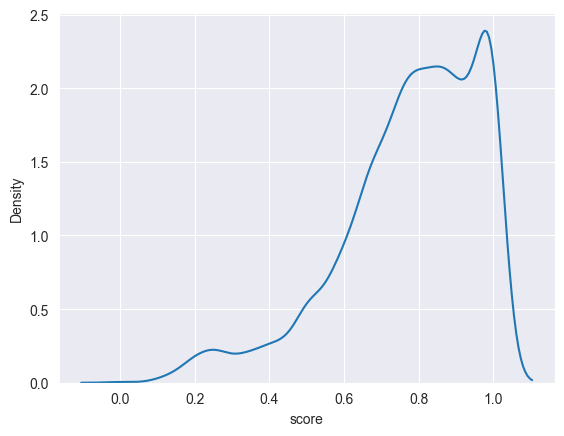

In [32]:
import seaborn as sns
# sns.ecdfplot(completed_routes_df["score"])
sns.kdeplot(completed_routes_df["score"], kernel="gau")
# plt.hist(completed_routes_df["score"], bins=80)

/Users/anko/opt/anaconda3/envs/RealDataClassificator/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/anko/opt/anaconda3/envs/RealDataClassificator/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


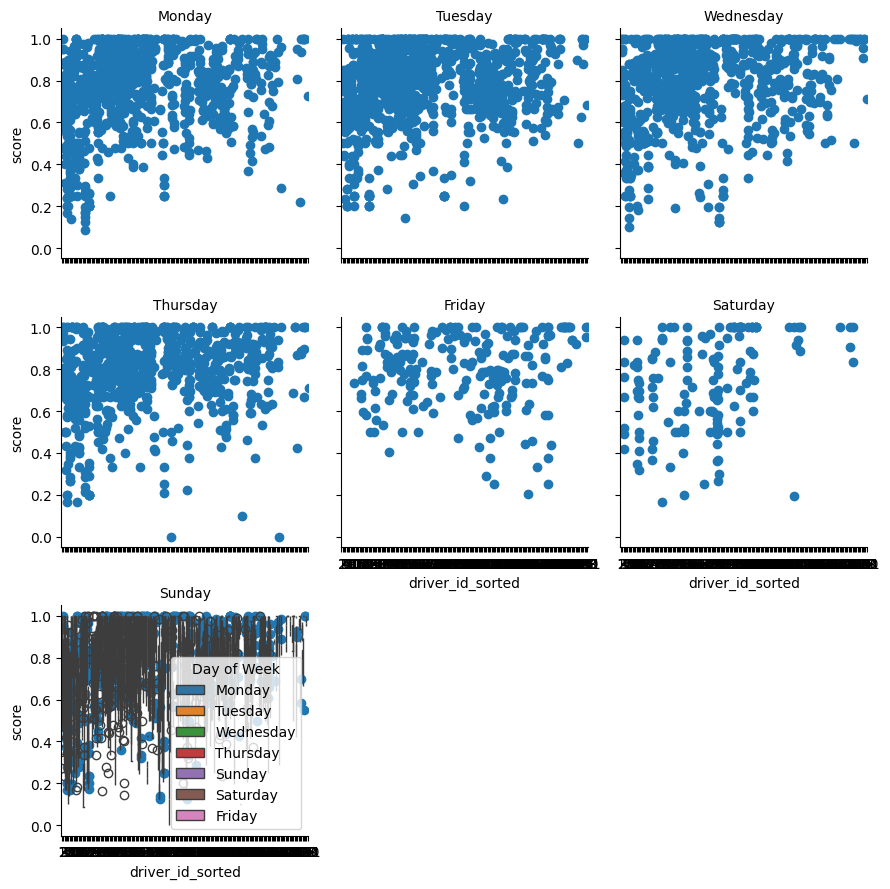

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a Pandas DataFrame called 'df'

# Faceted scatter plot
sns.FacetGrid(completed_routes_df, col="day_of_week", col_wrap=3) \
    .map(plt.scatter, "driver_id_sorted", "score") \
    .set_titles("{col_name}")

# Box plot with hue
sns.boxplot(x="driver_id_sorted", y="score", hue="day_of_week", data=completed_routes_df)
plt.legend(title="Day of Week")

In [39]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Correlation analysis
for day in completed_routes_df["day_of_week"].unique():
    day_df = completed_routes_df[completed_routes_df["day_of_week"] == day]
    corr_coef, p_value = pearsonr(day_df["driver_id_sorted"], day_df["score"])
    print(f"Day: {day}, Correlation Coefficient: {corr_coef:.2f}, p-value: {p_value:.2f}")

# ANOVA
formula = "score ~ C(driver_id_sorted) + C(day_of_week)"
model = ols(formula, data=completed_routes_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

Day: Monday, Correlation Coefficient: 0.21, p-value: 0.00
Day: Tuesday, Correlation Coefficient: 0.15, p-value: 0.00
Day: Wednesday, Correlation Coefficient: 0.24, p-value: 0.00
Day: Thursday, Correlation Coefficient: 0.19, p-value: 0.00
Day: Friday, Correlation Coefficient: 0.05, p-value: 0.45
Day: Saturday, Correlation Coefficient: 0.35, p-value: 0.00
Day: Sunday, Correlation Coefficient: 0.30, p-value: 0.00
                         sum_sq      df          F    PR(>F)
C(driver_id_sorted)   63.129473   190.0  14.242122  0.000000
C(day_of_week)         0.560427     6.0   4.003720  0.000529
Residual             105.985533  4543.0        NaN       NaN


In [26]:
sunday_count = completed_routes_df[completed_routes_df["day_of_week"] == "Sunday"].shape[0]
print(f"Number of rows on Sunday: {sunday_count}")

Number of rows on Sunday: 675


In [18]:
import folium
def build_route(lat_seq, lon_seq, color, earliest, latest, arrived, location_type_id, file_name, marker_bool = False):
    m = folium.Map(location=[lat_seq[0], lon_seq[0]], zoom_start=13)
    # Add a polyline with arrows
    offset = 0
    for i in range(len(lat_seq)):
        lat, lon = lat_seq[i], lon_seq[i]
        earliest_date = earliest[i]
        latest_date = latest[i]
        arrived_date = arrived[i]
        location_type = location_type_id[i]

        # Determine the marker color based on the arrived date being within the earliest and latest date range
        if marker_bool == False:
            marker_color = 'white'
        else:
            if earliest_date <= arrived_date <= latest_date:
                marker_color = 'green'
            else:
                marker_color = 'red'

        # Add an index label
        folium.Marker([lat + offset * 0.000001, lon + offset * 0.000001], icon=folium.DivIcon(html=f'<div style="font-size: 13pt; border: 1px solid white; border-radius: 50%; width: 1.2em; height: 1.2em; background-color: {marker_color}; border-radius: 50%;text-align: center;text-color: white;">{i+1}</div>')).add_to(m)

        # Add a red square marker for depots
        if location_type == 1:
            folium.Marker([lat + offset * 0.000001, lon + offset * 0.000001], icon=folium.Icon(color='red', icon='square', prefix='fa')).add_to(m)

        if i < len(lat_seq) - 1:
            next_lat, next_lon = lat_seq[i + 1], lon_seq[i + 1]
            angle = np.rad2deg(np.arctan2(next_lat - lat, next_lon - lon))
            arrow_lon = lon + 0.001 * np.cos(np.deg2rad(angle))

            # Add a line segment
            folium.PolyLine([[lat + offset * 0.000001, lon + offset * 0.000001], [next_lat, next_lon]], color=color, dash_array='5, 5').add_to(m)

            # Add an arrow at the end of the line segment
            folium.Marker([next_lat, next_lon], icon=folium.Icon(color=color, icon='arrow-up', prefix='fa')).add_to(m)

        # Increase the offset for the next node with the same location
        offset += 1

    m.save(file_name)

In [20]:
def draw_planned_route(row_id):
    lats = uncompleted_routes_df["current_lat"].iloc[row_id]
    lngs = uncompleted_routes_df["current_lng"].iloc[row_id]
    earliests = uncompleted_routes_df["stop_earliest"].iloc[row_id]
    latests = uncompleted_routes_df["stop_latest"].iloc[row_id]
    arriveds = uncompleted_routes_df["stop_arrived_at"].iloc[row_id]
    location_types = uncompleted_routes_df["location_type_id"].iloc[row_id]
    build_route(lats, lngs, 'blue', earliests, latests, arriveds, location_types, f'planned_route_{row_id}.html')


In [21]:
def draw_actual_route(row_id):
    mapping = {}
    row = uncompleted_routes_df.iloc[row_id]
    planned_route = row['planned_route_craft']
    actual_route = row['actual_route_location']
    longs = row['current_lng']
    lats = row['current_lat']
    earliest = row['stop_earliest']
    latest = row['stop_latest']
    arrived = row['stop_arrived_at']
    location_type_id = row['location_type_id']

    for i in range(len(planned_route)):
        mapping[planned_route[i]] = (longs[i], lats[i], earliest[i], latest[i],arrived[i], location_type_id[i])

    actual_longs = [mapping[location][0] for location in actual_route]
    actual_lats = [mapping[location][1] for location in actual_route]
    actual_earliest = [mapping[location][2] for location in actual_route]
    actual_latest = [mapping[location][3] for location in actual_route]
    actual_arrived = [mapping[location][4] for location in actual_route]
    actual_location_type_id = [mapping[location][5] for location in actual_route]


    build_route(actual_lats, actual_longs, 'red', actual_earliest, actual_latest, actual_arrived, actual_location_type_id, f'actual_route_{row_id}.html',True)

id = 13
draw_planned_route(id)
draw_actual_route(id)


In [206]:

# uncompleted_routes_df = uncompleted_routes_df.sample(n=len(completed_routes_df), random_state=42)
len(completed_routes_df), len(uncompleted_routes_df)
# completed_routes_df

(2412, 2328)

In [24]:
# completed_routes_list_unique = [array for i, array in enumerate(completed_routes_list) if array not in completed_routes_list[:i]]
# uncompleted_routes_list_unique = [array for i, array in enumerate(uncompleted_routes_list) if array not in uncompleted_routes_list[:i]]
# len(completed_routes_list_unique), len (uncompleted_routes_list_unique)
# len(completed_routes_df), len(uncompleted_routes_df)

In [ ]:
final_routes = pd.DataFrame({
    'routes': completed_routes_df['planned_route_craft'].tolist() + uncompleted_routes_df['planned_route_craft'].tolist(),
    'actual_routes': completed_routes_df['actual_route_location'].tolist() + uncompleted_routes_df['actual_route_location'].tolist(),
    'driver_id': completed_routes_df['driver_id'].tolist() +  uncompleted_routes_df['driver_id'].tolist(),
    'distance_route': completed_routes_df['distance_route'].tolist() + uncompleted_routes_df['distance_route'].tolist(),
    'last_two_weeks_count': completed_routes_df['last_two_weeks_count'].tolist() + uncompleted_routes_df['last_two_weeks_count'].tolist(),
    'current_lat': completed_routes_df['current_lat'].tolist() + uncompleted_routes_df['current_lat'].tolist(),
    'current_lng': completed_routes_df['current_lng'].tolist() + uncompleted_routes_df['current_lng'].tolist(),
    # 'day_of_week': completed_routes_df['day_of_week'].tolist() + uncompleted_routes_df['day_of_week'].tolist(),
    'label': [0] * len(completed_routes_df)  + [1] * len(uncompleted_routes_df)
})
final_routes['len'] = final_routes['routes'].apply(lambda x: len(x))
final_routes

# [0] * len(artificial_planned_routes)
# artificial_planned_routes['distance_route'].tolist()
# artificial_planned_routes['driver_id'].tolist()
# artificial_planned_routes['common_subsequence'].tolist()

In [243]:
#create dictionary and encode to smaller unique numbers
locations_dic = {}
location_count = {}
k = 1
for row in final_routes['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1

print(len(locations_dic))

for row in final_routes['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1


2965


In [ ]:
drivers_dic = {}
k = 1
for driver in final_routes['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)
final_routes

In [249]:
final_routes['experience_feature'] = final_routes.apply(lambda x: x['len'] * [x['last_two_weeks_count']], axis = 1)
final_routes['len_feature'] = final_routes.apply(lambda x: x['len'] * [x['len']], axis = 1)
final_routes['driver_id_feature'] = final_routes.apply(lambda x: x['len'] * [x['driver_id_sorted']], axis = 1)

final_routes

print('correlation', final_routes['len'].corr(final_routes['label']))
print('correlation', max(final_routes['len']))

correlation 0.002875984232286092
correlation 35


In [250]:
# import pandas as pd
# from sklearn.linear_model import LogisticRegression
#
# # One-hot encode categorical columns
# encoded_routes = pd.get_dummies(final_routes.drop(['routes'], axis=1), drop_first=True)
# # Train a Random Forest classifier
# model = LogisticRegression()
# model.fit(encoded_routes, final_routes['label'])
# coefs = model.coef_
#
# # Calculate odds ratio
# odds_ratios = np.exp(coefs)
# odds_ratios

In [251]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency
#
# # Convert categorical column to numerical representation
# driver_ids = final_routes['driver_id_sorted'].astype('category')
# driver_ids_encoded = driver_ids.cat.codes
#
# # Calculate contingency table
# contingency_table = pd.crosstab(driver_ids_encoded, final_routes['label'])
#
# # Perform Chi-square test for independence
# chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
#
# # Print the correlation matrix
# print("Correlation Matrix:")
# print(contingency_table)
# print(f"\nChi-square statistic: {chi2_stat:.4f}")
# print(f"p-value: {p_val:.4f}")
#
# # Interpret the results
# if p_val < 0.05:
#     print("The driver_id and label columns are significantly associated.")
# else:
#     print("The driver_id and label columns are not significantly associated.")

In [253]:
encoding_routes = []
for row in final_routes['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes['routes'] = encoding_routes


# Model

In [ ]:
def padding_(routes, route_len):
    features = np.zeros((len(routes), route_len),dtype=np.float16)
    for ii, route in enumerate(routes):
        if len(route) != 0:
            features[ii, -len(route):] = np.array(route)[:route_len]
    return features

X = final_routes.drop(columns = ['driver_id', 'label', 'last_two_weeks_count', 'len', 'driver_id_sorted'])
# print(X)
y = np.array(final_routes['label'])
print(X)

max_route_length = max(len(item) for item in X['routes'])
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), X.to_numpy()[:,2:]], axis=1)
X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), padding_(X['experience_feature'], max_route_length), padding_(X['len_feature'], max_route_length), padding_(X['driver_id_feature'], max_route_length)], axis=1)
X = X.astype(np.float16)
X = X.astype(int) #for boolean values, to converst from string to int
final_routes

## List of features

routes
distance_route
experience_feature
len_feature
driver_id_feature

Total: 175


In [256]:
from torch.utils.data import Dataset, DataLoader
import torch
import random

seed_value = 42
device = "cpu"


g = torch.Generator()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Additional steps if using DataLoaders (to ensure reproducibility in data loading)
torch.use_deterministic_algorithms(True)

def reset_random():
    g.manual_seed(seed_value)
    torch.manual_seed(seed_value)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [257]:
import torch #pytorch
import torch.nn as nn

In [258]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, vocab_size_len,hidden_dim,embedding_dim,embedding_dim_driv,embedding_dim_len, output_dim,additional_feature_count,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv
        self.vocab_size_len = vocab_size_len

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        self.embedding_len = nn.Embedding(vocab_size_len, embedding_dim_len)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim+embedding_dim_driv+1+embedding_dim_len+1,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        # self.fc = nn.Linear(self.hidden_dim + additional_feature_count, output_dim)
        # self.fc = nn.Linear(self.hidden_dim + embedding_dim_driv, output_dim) #withfeatures
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc = nn.Linear(36, output_dim)
        # self.fc = nn.Linear(1316, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_feature'].int()
        experience = x['experience_feature'].int()
        len_feature = x['len_feature'].int()
        distance = x['distance_route'].int()
        # latitudes = x['current_lat'].int()
        # longtitudes = x['current_lng'].int()
        embedding_driv = self.embedding_driv(driver_ids)
        embedding_len = self.embedding_len(len_feature)


        all_embeds = torch.concatenate((embeds, embedding_driv, embedding_len, experience.view(batch_size, max_route_length, 1),distance.view(batch_size, max_route_length, 1)), dim=2)

        lstm_out, _ = self.lstm(all_embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(out)
        # print(sig_out.shape)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [259]:
def get_model():
    no_layers = 2
    vocab_size = 2966 #extra 1 for padding
    vocab_size_driv = 196
    vocab_size_len = 36 #extra 1 for padding
    embedding_dim = 4 #was 64
    embedding_dim_driv = 2 #was 64
    embedding_dim_len = 2 #was 64
    output_dim = 1
    hidden_dim = 32 #was 64


    model = SentimentRNN(no_layers,vocab_size, vocab_size_driv, vocab_size_len, hidden_dim,embedding_dim, embedding_dim_driv,embedding_dim_len, output_dim,len(drivers_dic),drop_prob=0.5)
    model.train()
    print(model)
    return model

In [260]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

def get_precision(pred, label):
    pred = torch.round(pred.squeeze())
    true_positive = torch.sum((pred == 1) & (label.squeeze() == 1)).item()
    false_positive = torch.sum((pred == 1) & (label.squeeze() == 0)).item()

    if true_positive + false_positive == 0:
        return 0.0, true_positive, false_positive  # Handle the case where there are no predicted positives

    precision_value = true_positive / (true_positive + false_positive)
    return precision_value, true_positive, false_positive

In [261]:
def train_model(data, model, epochs = 20):
    train_loader, valid_loader = data
    lr=0.0005

    criterion = nn.BCELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    epoch_tr_precision,epoch_vl_precision = [],[]
    run_name = 'first_run_4'
    # wandb.init(project='Route_classification', name=f'{run_name}')

    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
        for inputs, labels in train_loader:
            # print(labels)

            model.zero_grad()
            # print(inputs.shape, h[0].shape, h[1].shape)
            output = model(inputs)

            # calculate the loss and perform backprop
            # print(output, labels)
            # print(output.shape, labels.shape)
            loss = criterion(output.view(-1), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,labels)
            precision = get_precision(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        val_losses = []
        val_acc = 0.0
        val_precision = 0.0
        val_tp = 0
        val_fp = 0
        model.eval()
        for inputs, labels in valid_loader:
                # inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output.view(-1), labels.float())
                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                precision = get_precision(output,labels)
                val_acc += accuracy
                val_precision += precision[0]
                val_tp += precision[1]
                val_fp += precision[2]

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        print(val_tp, val_fp)
        if val_tp + val_fp == 0:
            print('sum zero')
            val_prec = 0
        else:
            val_prec = val_tp / (val_tp + val_fp)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        print(f'val_precision : {val_prec * 100}')
        # wandb.log({
        #     'epoch_train_loss': epoch_train_loss,
        #     'epoch_val_loss': epoch_val_loss,
        #     'epoch_train_acc': epoch_train_acc*100,
        #     'epoch_val_acc': epoch_val_acc*100,
        #     'epoch_val_precision': val_prec*100
        # })
        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), f'{run_name}.pt')
            # torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'{run_name}.pt'))
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

In [262]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    brier_score_loss
)
import matplotlib.pyplot as plt

def get_stats(model, data):
    model.eval()
    y_pred = []
    y_pred_exact = []
    y = []
    for inputs, labels in data:
        y.extend(labels)
        results = model(inputs).detach()
        y_pred.extend(np.round(results))
        y_pred_exact.extend(results)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    quadratic_loss = np.mean(((1-np.array(y))-(1-np.array(y_pred_exact)))**2 + (np.array(y)-(np.array(y_pred_exact)))**2)
    brier_score = brier_score_loss(y, y_pred_exact)

    fpr, tpr, thresholds = roc_curve(y, y_pred_exact)
    roc_auc = auc(fpr, tpr)

    # precision, recall, thresholds = precision_recall_curve(y, y_pred_exact)
    average_precision = average_precision_score(y, y_pred_exact)

    conf_mat = confusion_matrix(y, y_pred)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc" : roc_auc,
        "average_precision": average_precision,
        "conf_matrix": conf_mat,
        "fpr": fpr,
        "tpr": tpr,
        "quadratic_loss": quadratic_loss,
        "brier_score": brier_score
    }


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)

stats = []

FEATURE_COLUMNS = ['routes', 'driver_id_feature','experience_feature', 'distance_route', 'len_feature']


class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {}
        for col in FEATURE_COLUMNS:
            feature = self.df[col].iloc[idx]
            if isinstance(feature, list):
                feature = padding_([feature], max_route_length)[0]
            item[col] = feature
        item['label'] = self.df['label'].iloc[idx]
        return item, item['label']

def get_data_loaders(train_df, test_df):
    # create Tensor datasets
    train_data = DataFrameDataset(train_df)
    valid_data = DataFrameDataset(test_df)

    # dataloaders
    batch_size = 64

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    return train_loader, valid_loader

shuffled_df = final_routes.sample(frac=1, random_state=42).reset_index(drop=True)

for train_index, test_index in kf.split(shuffled_df, shuffled_df['label']):
    train_df = shuffled_df.iloc[train_index]
    test_df = shuffled_df.iloc[test_index]

    train_loader, valid_loader = get_data_loaders(train_df, test_df)
    print(f'len(train_df) = {len(train_df)}, len(test_df) = {len(test_df)}')
    model = get_model()
    model.train()

    train_model((train_loader, valid_loader), model, epochs=30)
    stats.append(get_stats(model, valid_loader))

acc: 0.6911392405063291
precision: 0.6832550505845079
recall: 0.6932699422820778
f1: 0.687428947512343
roc_auc: 0.7664326792360197
average_precision: 0.7623100014878655
quadratic_loss: 0.4075713883589101
brier_score: 0.20378569421999196


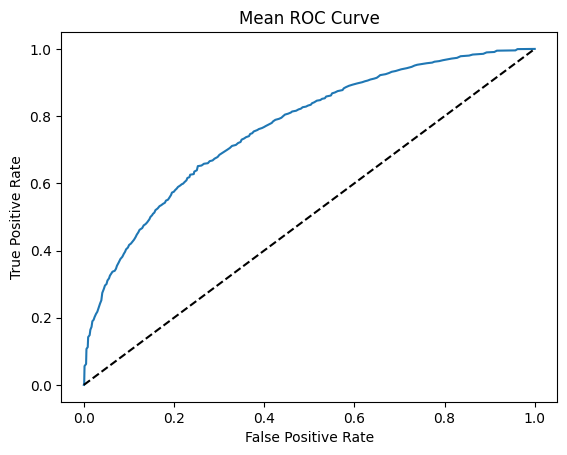

In [233]:
def get_mean_stat(stats, stat_name):
    if stat_name in ["fpr", "tpr"]:
        # Calculate mean fpr and tpr
        values = [item[stat_name] for item in stats]
        min_len = min(len(value) for value in values)
        interpolated_values = []
        for value in values:
            interpolated = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(value)), value)
            interpolated_values.append(interpolated)
        mean_values = np.array(interpolated_values).mean(axis=0)
        return mean_values
    else:
        # Calculate mean for other stats
        arr = np.array([item[stat_name] for item in stats])
        return arr.mean()

print('acc:', get_mean_stat(stats, 'acc'))
print('precision:', get_mean_stat(stats, 'precision'))
print('recall:', get_mean_stat(stats, 'recall'))
print('f1:', get_mean_stat(stats, 'f1'))
print('roc_auc:', get_mean_stat(stats, 'roc_auc'))
print('average_precision:', get_mean_stat(stats, 'average_precision'))
print('quadratic_loss:', get_mean_stat(stats, 'quadratic_loss'))
print('brier_score:', get_mean_stat(stats, 'brier_score'))
mean_fpr = get_mean_stat(stats, 'fpr')
mean_tpr = get_mean_stat(stats, 'tpr')

plt.plot(mean_fpr, mean_tpr)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
#
# reset_random()
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=seed_value)
# train_loader, valid_loader = get_data_loaders(X_train, y_train, X_val, y_val)
#
# model = get_model()
# # summary(model, input_size=(1,9))
# model.train()
#
# train_model((train_loader, valid_loader), model, epochs=50)
#
# get_stats(model, valid_loader)

In [ ]:
get_stats(model, valid_loader)
# def get_mean_stat(stats, stat_name) -> float:
#     return np.array([item[stat_name] for item in stats]).mean()
#
# print('acc:', get_mean_stat(stats, 'acc'))
# print('precision:', get_mean_stat(stats, 'precision'))
# print('recall:', get_mean_stat(stats, 'recall'))
# print('f1:', get_mean_stat(stats, 'f1'))
# print('roc_auc:', get_mean_stat(stats, 'roc_auc'))
# print('average_precision:', get_mean_stat(stats, 'average_precision'))